In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
K = tf.keras.backend
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import Callback

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Generated dataset shapes:
X_train shape: (1, 48, 128, 1)
y_train shape: (1, 5, 5)


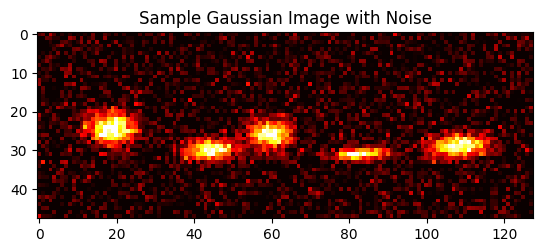

Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):
[[ 1.8844149e+01  2.4393234e+01  4.2415009e+00  3.0457664e+00
   8.4434852e-02]
 [ 4.4430607e+01  2.9930662e+01  4.5391536e+00  1.9000295e+00
  -5.8843773e-02]
 [ 5.9823471e+01  2.5920506e+01  3.6220548e+00  2.5157661e+00
   6.8548359e-02]
 [ 8.3027016e+01  3.0934032e+01  4.5750804e+00  1.0322950e+00
  -5.6498230e-02]
 [ 1.0844603e+02  2.8862556e+01  5.3074541e+00  1.9382192e+00
  -6.2788323e-02]]


In [7]:
def generate_gaussian_blob(image_size, mean, cov, angle, noise_std=0.01):
    """
    Generate a single Gaussian blob on an image with added random noise.
    """
    x, y = np.meshgrid(np.linspace(0, image_size[0] - 1, image_size[0]),
                       np.linspace(0, image_size[1] - 1, image_size[1]))
    x -= mean[0]
    y -= mean[1]

    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)

    x_rot = cos_angle * x + sin_angle * y
    y_rot = -sin_angle * x + cos_angle * y

    exponent = (x_rot ** 2) / (2 * cov[0] ** 2) + (y_rot ** 2) / (2 * cov[1] ** 2)
    blob = np.exp(-exponent)

    # Add random noise centered around the Gaussian blob
    noise = np.random.normal(0, noise_std, blob.shape)
    blob += noise

    return blob

def convert_parameters(parameters):
    """
    Convert Gaussian parameters from (amplitude, x0, y0, sigma_x, sigma_y) to (mean_x, mean_y, cov_x, cov_y, theta).
    """
    A, x0, y0, sigma_x, sigma_y = parameters
    
    mean_x = x0
    mean_y = y0
    cov_x = sigma_x
    cov_y = sigma_y
    
    # Calculate theta from the covariance values
    if cov_x != 0 and cov_y != 0:
        theta = 0.5 * np.arctan2(2 * cov_x * cov_y, (cov_x**2 - cov_y**2))
    else:
        theta = 0.0
    
    return mean_x, mean_y, cov_x, cov_y, theta

def create_training_data(num_samples, image_size=(128, 48), num_blobs=5, noise_std=0.05):
    """
    Create training data with Gaussian blobs and noise for the YOLO-style model.
    """
    X = np.zeros((num_samples, image_size[1], image_size[0], 1), dtype=np.float32)
    y = np.zeros((num_samples, num_blobs, 5), dtype=np.float32)

    for i in range(num_samples):
        image = np.zeros((image_size[1], image_size[0]), dtype=np.float32)
        blob_params = []

        # Generate y-values within 20% of each other
        base_y = np.random.uniform(0.4 * image_size[1], 0.6 * image_size[1])
        y_values = np.random.uniform(base_y * 0.8, base_y * 1.2, num_blobs)

        # Generate evenly spaced x-values with slight variation
        x_values = np.linspace(0, image_size[0], num_blobs + 2)[1:-1]
        x_values += np.random.uniform(-5, 5, num_blobs)

        for j in range(num_blobs):
            mean_x = x_values[j]
            mean_y = y_values[j]
            cov_x = np.random.uniform(2, 6)
            cov_y = np.random.uniform(1, 5)
            theta = np.random.uniform(-10, 10) * np.pi / 180  # Cap rotation at 10 degrees

            blob = generate_gaussian_blob((image_size[0], image_size[1]), (mean_x, mean_y), (cov_x, cov_y), theta, noise_std)
            image += blob

            # Store parameters for the label
            blob_params.append((mean_x, mean_y, cov_x, cov_y, theta))

        # Convert parameters to labels
        for j in range(num_blobs):
            mean_x, mean_y, cov_x, cov_y, theta = blob_params[j]
            y[i, j, :] = [mean_x, mean_y, cov_x, cov_y, theta]

        X[i, :, :, 0] = np.clip(image, 0, 1)

    return X, y

num_samples = 1  # Number of training samples
X_train, y_train = create_training_data(num_samples, noise_std=0.05)

print("Generated dataset shapes:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
plt.imshow(X_train[0].squeeze(), cmap='hot')
plt.title("Sample Gaussian Image with Noise")
plt.show()
print("Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):")
print(y_train[0])

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class CropLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(CropLayer, self).__init__(**kwargs)

    def call(self, inputs):
        image, crop_boxes = inputs
        batch_size = tf.shape(image)[0]
        num_boxes = tf.shape(crop_boxes)[1]
        crop_boxes = tf.reshape(crop_boxes, (batch_size * num_boxes, 4))  # Flatten the crop_boxes tensor
        box_indices = tf.range(batch_size)
        box_indices = tf.repeat(box_indices, repeats=num_boxes)
        
        cropped_images = tf.image.crop_and_resize(
            image, crop_boxes, box_indices, (20, 20)
        )
        
        return cropped_images

def build_cnn_with_gaussian_prediction(input_shape):
    # Input layer
    inputs = layers.Input(shape=input_shape)
   
    # Initial convolutions to process the full image
    x = layers.Conv2D(8, kernel_size=3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
   
    # Predict 5 crop areas
    crop_pred = layers.Conv2D(16, kernel_size=3, activation='relu', padding='same')(x)
    crop_pred = layers.Flatten()(crop_pred)
    crop_pred = layers.Dense(64, activation='relu')(crop_pred)
    crop_pred = layers.Dense(5 * 4, activation='sigmoid', name='crop_prediction')(crop_pred)
   
    # Reshape crop predictions to [batch_size, 5, 4] format
    crop_boxes = layers.Reshape((5, 4))(crop_pred)
   
    # Crop the original input image
    cropped_images = CropLayer()([inputs, crop_boxes])
   
    x = layers.Conv2D(16, kernel_size=3, strides=1, padding='same')(cropped_images)
    x = layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05)(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(5)(x)
    
    #got rid of crop_pred output
    model = Model(inputs=inputs, outputs=[outputs, crop_pred])
    return model

# Example usage
input_shape = (48, 128, 1)
model = build_cnn_with_gaussian_prediction(input_shape)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 48, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 24, 64, 8) │         80 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 12, 32, 8) │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 6, 16, 16) │      1,168 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 3, 8, 16)  │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 3, 8, 16)  │      2,320 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 384)       │          0 │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     24,640 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ crop_prediction     │ (None, 20)        │      1,300 │ dense_4[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 5, 4)      │          0 │ crop_prediction[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ crop_layer_1        │ (None, 20, 20, 1) │          0 │ input_layer_4[0]… │
│ (CropLayer)         │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 20, 20,    │        160 │ crop_layer_1[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │         80 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 20, 20,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 10, 10,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 10, 10,    │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │         40 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 10, 10,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 5, 5, 32)  │          0 │ re_lu_3[0][0]   

 Total params: 145,537 (568.50 KB)

 Trainable params: 145,477 (568.27 KB)

 Non-trainable params: 60 (240.00 B)

X_train shape: (40000, 48, 128, 1)
y_train shape: (40000, 5, 5)
X_val shape: (10000, 48, 128, 1)
y_val shape: (10000, 5, 5)


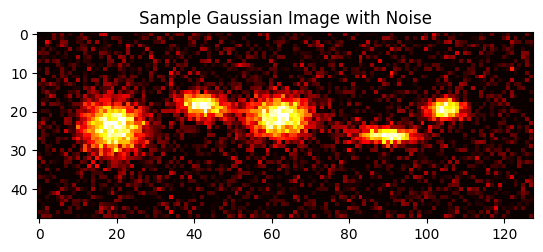

Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):
[[ 2.45478783e+01  2.56053886e+01  3.54595256e+00  3.77038407e+00
  -6.75850585e-02]
 [ 3.89619141e+01  2.05881310e+01  2.50217080e+00  4.11926174e+00
  -1.44949794e-01]
 [ 6.89940338e+01  1.87230644e+01  2.46363997e+00  4.12068939e+00
   6.95203170e-02]
 [ 8.76430893e+01  2.34191856e+01  4.45137453e+00  3.02685809e+00
  -5.68770170e-02]
 [ 1.05775215e+02  2.43807354e+01  2.69923115e+00  3.66339636e+00
   9.08237621e-02]]


In [8]:
# Generate the training data
num_samples = 50000
X, y = create_training_data(num_samples)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], 48, 128, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 128, 1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Visualize a sample image and its Gaussians
plt.imshow(X_train[0].squeeze(), cmap='hot')
plt.title("Sample Gaussian Image with Noise")
plt.show()

print("Sample Gaussian parameters (mean_x, mean_y, cov_x, cov_y, theta):")
print(y_val[0])

In [13]:
def gaussian_loss(y_true, y_pred):
    # Reshape y_true and y_pred to ensure compatibility
    y_true = tf.reshape(y_true, [-1, 5, 1])
    y_pred = tf.reshape(y_pred, [-1, 5, 1])

    # Separate the true and predicted parameters
    true_meanx, true_meany, true_covx, true_covy, true_theta = tf.split(y_true, 5, axis=1)
    pred_meanx, pred_meany, pred_covx, pred_covy, pred_theta = tf.split(y_pred, 5, axis=1)

    # Compute the Mean Squared Error for each parameter
    meanx_loss = tf.reduce_mean(tf.square(true_meanx - pred_meanx) / 127.0)
    meany_loss = tf.reduce_mean(tf.square(true_meany - pred_meany) / 48.0)
    covx_loss = tf.reduce_mean(tf.square(true_covx - pred_covx) / 6.0)
    covy_loss = tf.reduce_mean(tf.square(true_covy - pred_covy) / 5.0)
    theta_loss = tf.reduce_mean(tf.square(true_theta - pred_theta) / 0.175)

    # Weighted sum of the losses
    loss = meanx_loss + meany_loss + covx_loss + covy_loss + theta_loss
    
    return loss

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
model = build_cnn_with_gaussian_prediction(input_shape)

model.compile(optimizer='adam', loss = gaussian_loss)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 18.9896

W0000 00:00:1723056443.792134  122678 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -4 } dim { size: 48 } dim { size: 128 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -2 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 48 } } device { type: "CPU" vendor: "AuthenticAMD" model: "241" frequency: 2999 num_cores: 32 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 134217728 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size

250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 18.8954 - val_loss: 1.0088
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 1.0337 - val_loss: 0.9126
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.9213 - val_loss: 0.8897
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.8853 - val_loss: 0.7975
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.8267 - val_loss: 0.8026
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.7879 - val_loss: 0.7489
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.7648 - val_loss: 0.7814
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.7338 - val_loss: 0.7399
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.6998 - val_loss: 0.6821
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.6615 - val_loss: 0.6744
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.6590 - val_loss: 0.6742
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/s

In [122]:
X_test, y_test = create_training_data(1)
y_pred = model.predict(X_test)
y_test = np.array(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [124]:
print(y_pred.shape)
y_test = tf.squeeze(y_test)
print(y_test.shape)

(5, 5)
(5, 5)


In [117]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_gaussians_from_predictions(predictions, image_shape=(48, 128), threshold=0.1):
    # Create an empty image
    image = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.uint8)

    for i in range(predictions.shape[0]):  # Iterate over each prediction
        meanx, meany, covx, covy, theta = predictions[i]
        meanx, meany = meanx * image_shape[1] / 128, meany * image_shape[0] / 48  # Scale coordinates

        # Only plot if covx and covy are noticeably above the threshold
        if covx > threshold and covy > threshold:
            # Draw the Gaussian blob on the image
            draw_blob(image, meanx, meany, covx, covy, theta)

    # Convert BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.title('Generated Gaussians from Predictions')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.show()

def draw_blob(image, meanx, meany, covx, covy, theta):
    center = (int(meanx), int(meany))
    axes = (int(2 * covx), int(2 * covy))  # 2 standard deviations
    angle = np.degrees(theta)
    color = (0, 0, 255)  # Red color
    thickness = 2

    # Draw the ellipse on the image
    cv2.ellipse(image, center, axes, angle, 0, 360, color, thickness)

tf.Tensor(
[[ 1.81353436e+01  2.49173164e+01  5.57545042e+00  4.92705250e+00
  -2.15437338e-02]
 [ 3.94108467e+01  2.51563644e+01  2.06163168e+00  2.88591099e+00
  -1.36883944e-01]
 [ 6.00142021e+01  2.03703289e+01  3.46691418e+00  3.43505549e+00
   1.30418718e-01]
 [ 8.94377747e+01  2.42394352e+01  4.75138569e+00  2.60481310e+00
  -1.03755146e-01]
 [ 1.10228271e+02  2.71147556e+01  2.11833167e+00  1.96014869e+00
  -1.61844417e-01]], shape=(5, 5), dtype=float32)


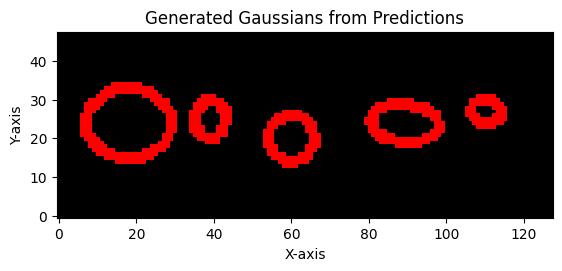

In [125]:
print(y_test)
plot_gaussians_from_predictions(y_test)

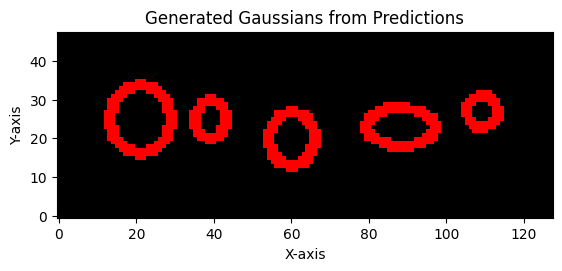

In [126]:
plot_gaussians_from_predictions(y_pred)

ValueError: setting an array element with a sequence.

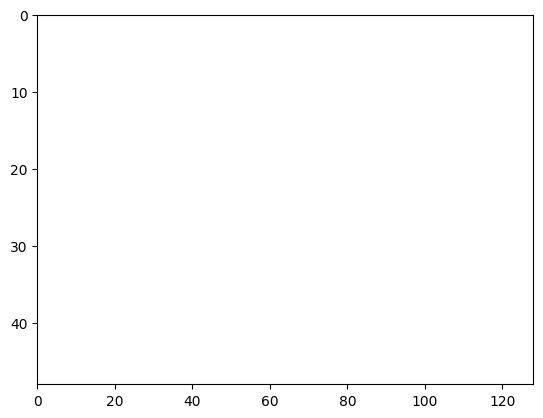

In [27]:
plot_gaussian_blobs(y_test)